In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wordcloud import WordCloud

from articles_clicks_links import plot_regression_clicks_links

In this notebook we will: 
- find how often each article is used in the Wikispeedia game (i.e. how many times each article was clicked on)
- find articles that are most/least used (+ to which country they are associated)
- find number of links in and out of each article (+ name of those linked articles)


- link each article to its category 
- find most used categories

# Import data 

Run the cell below to generate th dataframe containing the following columns: 
- **Top_1_name** = name of the country that occurs the most in the article
- **Top_2_name** = name of the country that occurs the second most in the article
- **Top_1_count** = number of times that the Top1 country occurs
- **Top_2_count** = number of times that the Top2 country occurs
- **click_count** = number of times the article occurs in the clicking paths of the Wikispeedia game
- **num_links_in** = number of articles that lead to article of interest 
- **name_links_in** = name of the artciles that lead to article of interest
- **num_links_out** = number of links in the article of interest, leading out of the article
- **name_links_out** = name of the articles that are references by the article of interest 

Each row is an article. 

In [5]:
#!python articles_clicks_links.py

In [6]:
df_country_clicks_links = pd.read_csv('data/country_clicks_links.csv', index_col=0)
df_country_clicks_links

,Top_1_name,Top_2_name,Top_1_count,Top_2_count,click_count,num_links_in,name_links_in,num_links_out,name_links_out
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,ireland,isle of man,8.0,4.0,0,NaN,NaN,11.0,"['Bede', 'Columba', 'D%C3%A1l_Riata', 'Great_B..."
%C3%85land,finland,åland islands,36.0,16.0,4,NaN,NaN,19.0,"['20th_century', 'Baltic_Sea', 'Crimean_War', ..."
%C3%89douard_Manet,italy,france,2.0,2.0,7,NaN,NaN,20.0,"['Absinthe', 'Beer', 'Claude_Monet', 'Diego_Ve..."
%C3%89ire,ireland,canada,43.0,4.0,13,NaN,NaN,8.0,"['Canada', 'English_language', 'George_VI_of_t..."
%C3%93engus_I_of_the_Picts,ireland,NaN,9.0,NaN,0,NaN,NaN,10.0,"['D%C3%A1l_Riata', 'Durham', 'England', 'Great..."
...,...,...,...,...,...,...,...,...,...
Zirconium,NaN,NaN,NaN,NaN,34,15.0,"['Calcium', 'Cerium', 'Diamond_simulant', 'Gas...",42.0,"['Aluminium', 'Arabic_language', 'Australia', ..."
Zoroaster,tajikistan,iran,3.0,3.0,20,9.0,"['Friedrich_Nietzsche', 'Greco-Buddhism', 'Ira...",28.0,"['18th_century', '9th_century', 'Afghanistan',..."
Zuid-Gelders,netherlands,germany,2.0,2.0,10,5.0,"['Brabantian', 'Dutch_language', 'East_Flemish...",5.0,"['Brabantian', 'Dutch_language', 'East_Flemish..."
Zulu,south africa,zimbabwe,7.0,3.0,55,14.0,"['19th_century', 'Africa', 'History_of_South_A...",NaN,NaN


# Visualization of article usage in the Wikispeedia game

First we have to sorte the data by click count in descending order!

In [7]:
df_country_clicks_links_sorted = df_country_clicks_links.sort_values(by='click_count', ascending=False)

## Most used articles

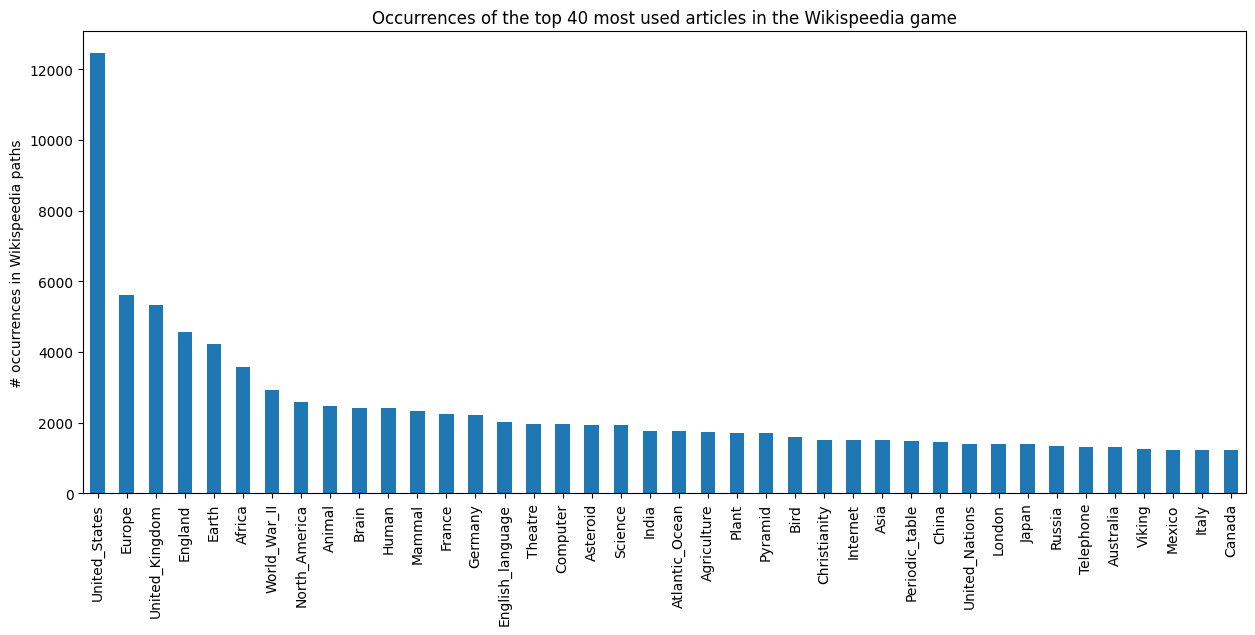

In [8]:
# plot the most used articles 
df_country_clicks_links_sorted['click_count'].head(40).plot(kind='bar', stacked=True, figsize=(15, 6))

plt.xticks(ticks=range(len(df_country_clicks_links_sorted.head(40))), labels=df_country_clicks_links_sorted.index.tolist()[0:40], fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')
# Set the y-axis to a log scale
#plt.yscale('log') ???????
plt.title("Occurrences of the top 40 most used articles in the Wikispeedia game")
plt.show()

We see that the most used article is United_States. This article is much more used that all other articles which have roughly the same click number. 

**Which countries are most represented within the most used articles?**

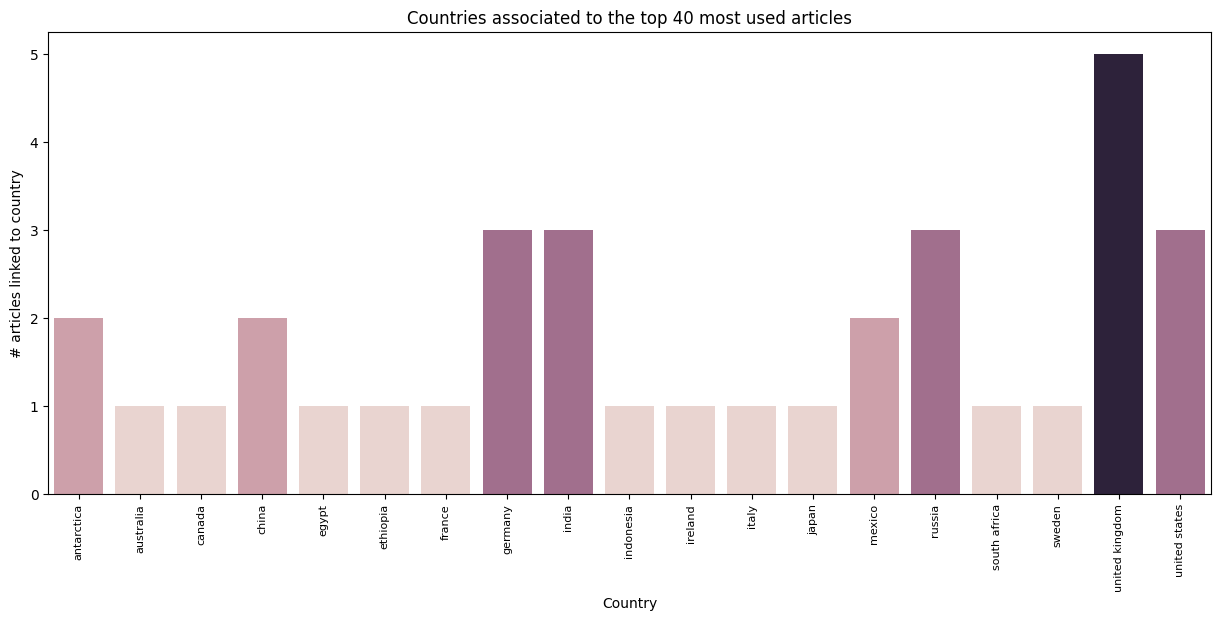

In [9]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=df_country_clicks_links_sorted.head(40).groupby("Top_1_name").count(), legend=False)

plt.xticks(fontsize=8, rotation=90)
plt.ylabel('# articles linked to country')
plt.xlabel("Country")
plt.title("Countries associated to the top 40 most used articles")
plt.show()

We see that the top 40 most used articles belong mostly to the United Kingdom, United States, Russia, India and Germany.

**Which countries are most clicked?**

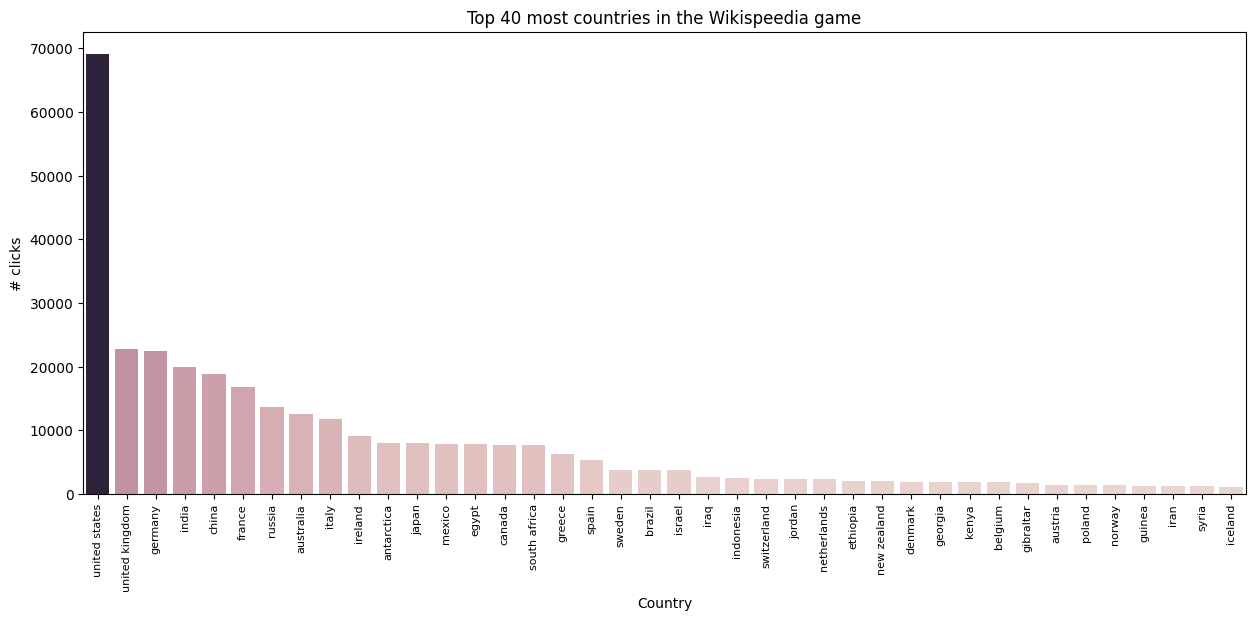

In [10]:
country_clicks = df_country_clicks_links.groupby('Top_1_name')['click_count'].sum().reset_index()
sorted_country_clicks = country_clicks.sort_values(by='click_count', ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=sorted_country_clicks.head(40), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.head(40))), labels=sorted_country_clicks['Top_1_name'].head(40), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Top 40 most countries in the Wikispeedia game")
plt.show()

The country that is clicked the most is United States.

## Least used articles

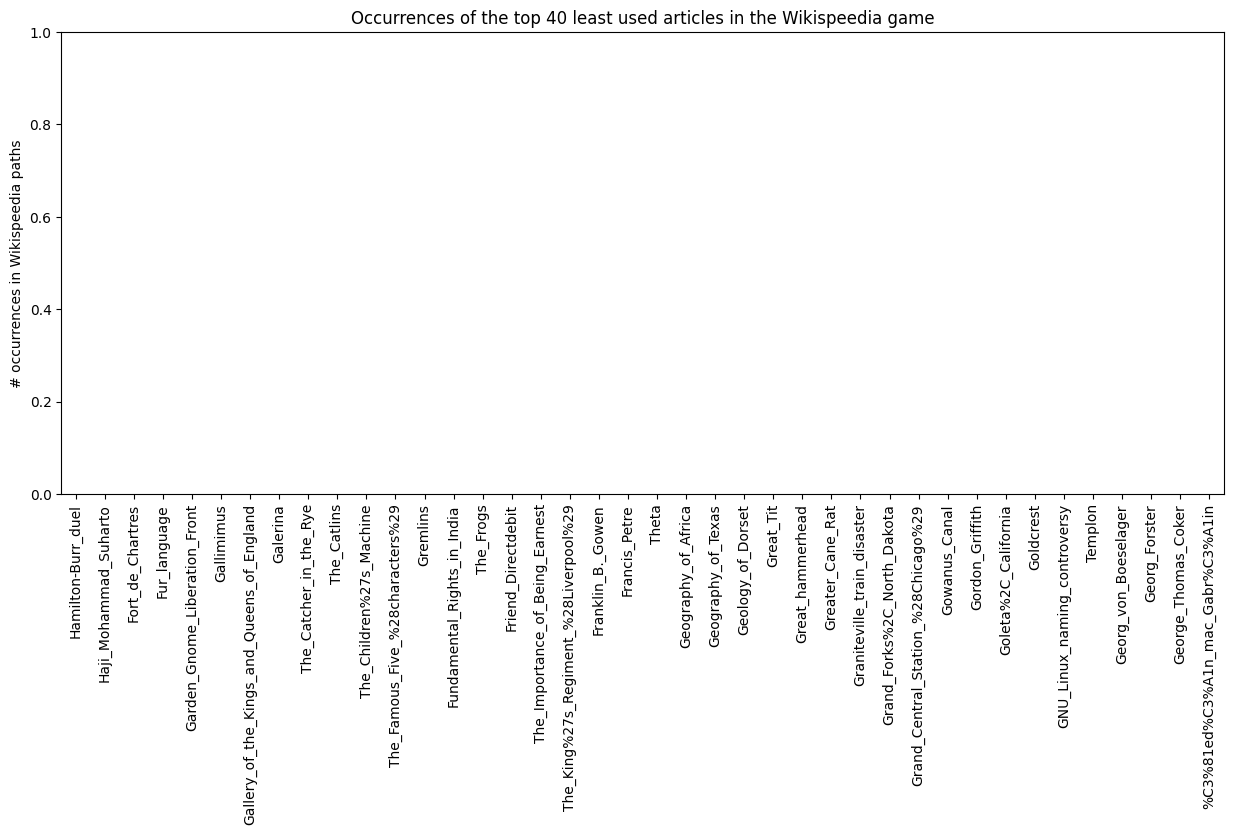

In [11]:
# plot the least used articles 
df_country_clicks_links_sorted['click_count'].tail(40).plot(kind='bar', stacked=True, figsize=(15, 6))

plt.xticks(ticks=range(len(df_country_clicks_links_sorted.tail(40))), labels=df_country_clicks_links_sorted.index.tolist()[-40:], fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')
plt.ylim([0,1])
plt.title("Occurrences of the top 40 least used articles in the Wikispeedia game")
plt.show()

# so many articles are never used (never clicked :( sniiif)

In [12]:
# find articles that are never clicked on
never_used_articles = df_country_clicks_links[df_country_clicks_links['click_count'] == 0]
print(f'there are {len(never_used_articles)} articles that are never clicked on in the game')

there are 422 articles that are never clicked on in the game


We see that there are many articles that are never used.

**Which countries are most represented within the least used articles?**

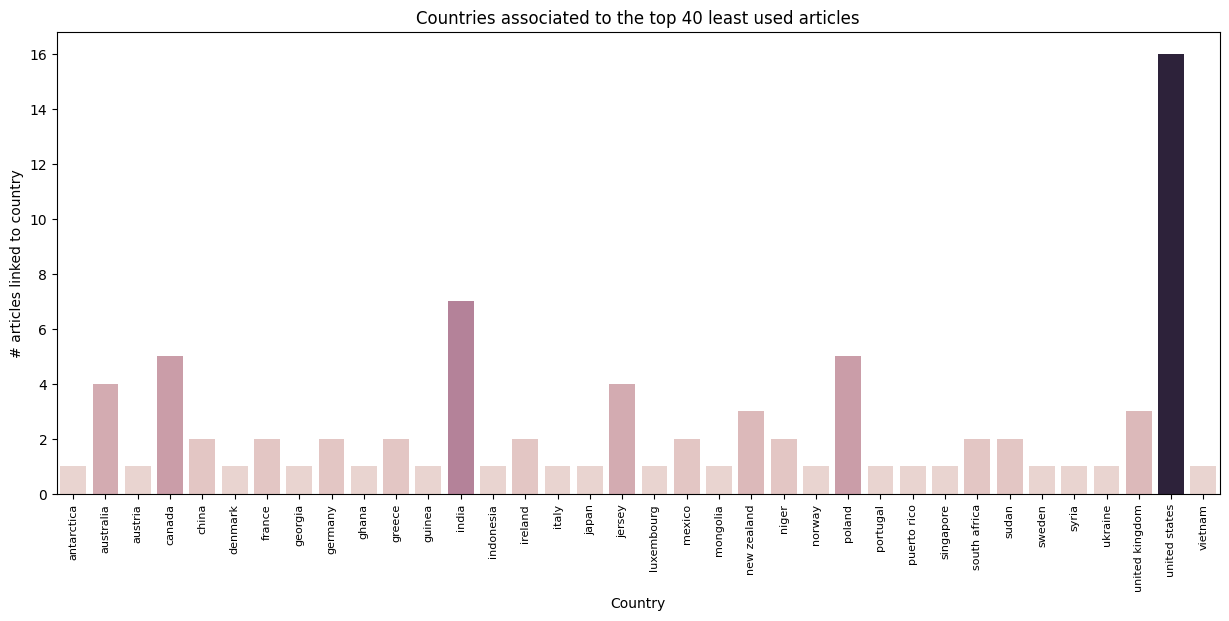

In [13]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=df_country_clicks_links_sorted.tail(100).groupby("Top_1_name").count(), legend=False)

plt.xticks(fontsize=8, rotation=90)
plt.ylabel('# articles linked to country')
plt.xlabel("Country")
plt.title("Countries associated to the top 40 least used articles")
plt.show()

We see that also among the 40 least used articles, the United States are the leading country, by far. 

## Articles that are nerver used and/or that are associated to no country

In [14]:
no_country_articles = df_country_clicks_links[df_country_clicks_links['Top_1_name'].isna() == True]
print(f'there are {len(no_country_articles)} articles that are associated to no country')

nerver_used_no_country = np.intersect1d(never_used_articles.index.tolist(), no_country_articles.index.tolist()).tolist()
print(f'there are {len(nerver_used_no_country)} articles that are associated to no country AND that are never clicked --> least interesting articles')

there are 887 articles that are associated to no country
there are 74 articles that are associated to no country AND that are never clicked --> least interesting articles


## Word cloud representation of articles

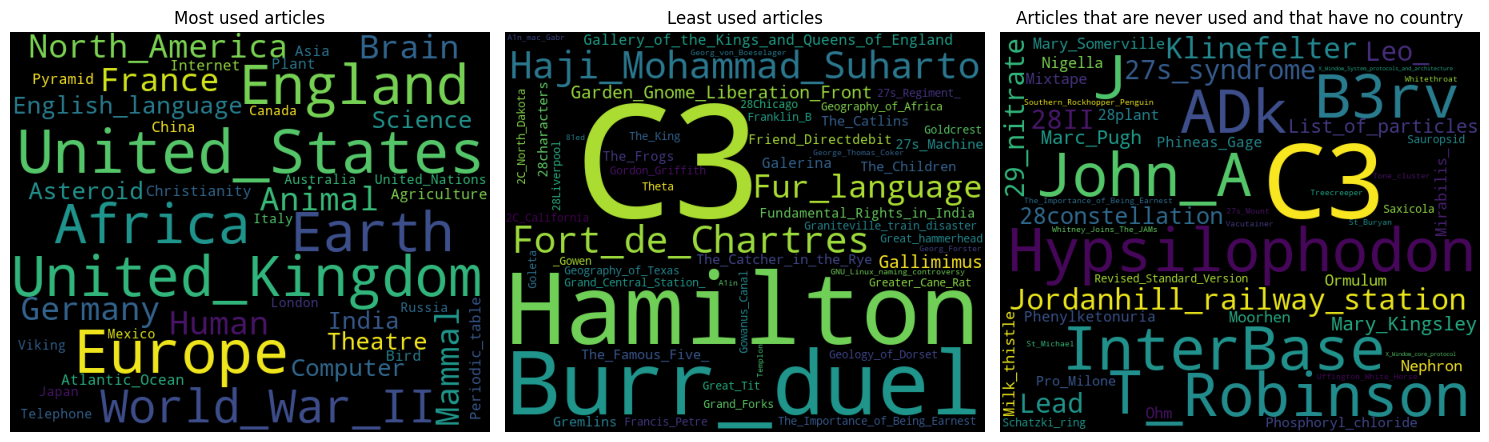

In [15]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Generate the word cloud for the most used articles
unique_string_most = (" ").join(list(df_country_clicks_links_sorted.index.tolist()[0:40]))
wordcloud_most = WordCloud(width=600, height=500).generate(unique_string_most)

# Plot the word cloud for the most used articles
axes[0].imshow(wordcloud_most)
axes[0].set_title("Most used articles")
axes[0].axis("off")

# Generate the word cloud for the least used articles
unique_string_least = (" ").join(list(df_country_clicks_links_sorted.index.tolist()[-40:]))
wordcloud_least = WordCloud(width=600, height=500).generate(unique_string_least)

# Plot the word cloud for the least used articles
axes[1].imshow(wordcloud_least)
axes[1].set_title("Least used articles")
axes[1].axis("off")

# Generate the word cloud for the articles that are never used and that have no country
unique_string_no = (" ").join(list(nerver_used_no_country[-40:]))
wordcloud_no = WordCloud(width=600, height=500).generate(unique_string_no)

# Plot the word cloud for the articles that are never used and that have no country
axes[2].imshow(wordcloud_no)
axes[2].set_title("Articles that are never used and that have no country")
axes[2].axis("off")

# Display the subplots
plt.tight_layout()
plt.show()

# Confounding factors

It could be that certain articles are clicked more often simply because they contain more links and this information might be intuitively known by the players of the Wikispeedia game which could explain way they tend to click on those "link hub" articles. It could also be that the articles that are most clicked are those that are most cited in other articles. This would mean that players have higher chances to encounter those articles which could explain the higher click count. 

To investigate those 2 hypotheses, we will look at the correlations between the number of clicks and the number of links in and out of articles. 

TypeError: plot_regression_clicks_links() missing 1 required positional argument: 'title'

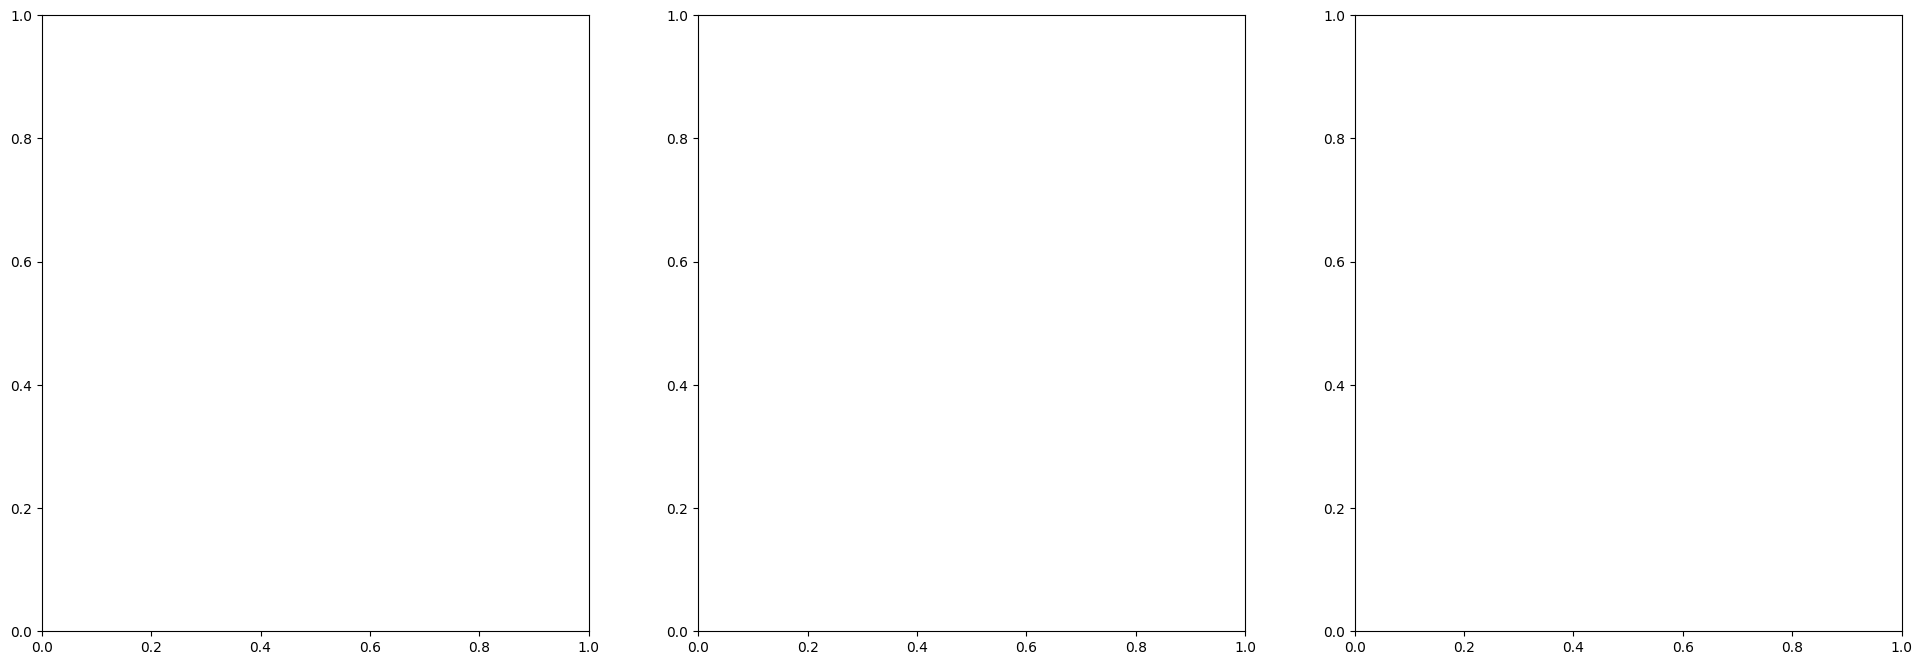

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

plot_regression_clicks_links('num_links_in', 'click_count', axes[0], [1100, 1000], "# links in", "# clicks", "Number of clicks in function of the number of links leading to articles")
plot_regression_clicks_links('num_links_out', 'click_count', axes[1], [200, 2000], "# links out", "# clicks", "Number of clicks in function of hte number of links going out of the articles")
plot_regression_clicks_links('num_links_out', 'num_links_in', axes[2], [200, 800], "# links out", "# links in", "Number of links out of articles in function of number of links into articles")

## Log-transform click counts 